# Predicting Housing Prices in King County, Washington

#### Griffin Hundley, Malcolm Katzenbach, and Lauren Phipps


***

### Overview  <a id="Overview"></a>

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

[1. Business Problem](#Business-Problem)

[2. Data Understanding](#Data-Understanding)

[3. Data Cleaning](#Data-Cleaning)

[4. Data Modeling](#Data-Modeling)

[5. Evaluation](#Evaluation)

[6. Conclusion](#Conclusion)

***

## Business Problem  <a id="Business-Problem"></a>

When listing a house for sale, it is important to price it accurately. Houses that are priced too high can sit on the market for months, which can lead to the price eventually being dropped to generate sales. According to a study from Zillow, in the Seattle area, a house that is on the market for 2 months will lead to a 5% drop in price. On the other side, if a house is priced too low, a seller is not maximizing the return on their house. In both of these cases, the seller is not getting as much money as they can and the realtor is not maximizing their commission for the sale, as commission is tied to selling price. 

To combat this, we are creating a model to estimate the price of a home based on certain characterisitics of the house. This will allow realtors to more accurately price the house to ensure it sells quickly and at a fair price. 

The questions we are targeting are:

   1) Which house features most impact the price of house?

   2) How do these feature impact the price of a house?
   
   3) Do renovations significantly increase the price of a property?
***

## Data Understanding  <a id="Data-Understanding"></a>

The data being used is publicly available housing data from King County, Washington from 2014-2015. The dataset contains ~21,600 rows, with each row representing the sale of a house in King County. The columns represent features of that house. The target variable is the price of the house, which will be used to determine the effect of several features on houses.  Prior to any data analysis, the test data is split from the training data to prevent data leakage. The split is 80% training, 20% testing.

### Columns

- `bedrooms`: number of bedrooms
- `bathrooms`: number of bathrooms
- `sqft_living`: Square Foot Living Space
- `sqft_lot`: Square Foot of Lot
- `floors`: number of floors
- `sqft_lot15`: Square Footage of nearest 15 lots
- `has_been_renovated`: House has been renovated before
- `ratio_15`: Ratio of sqft_living to sqft_living15
- `waterfront`: Is a waterfront property
- `grade`: King County Building Grade
- `sqft_above`: Above Ground Square Footage
- `yr_built`: Year building was built
- `years_old`: Age of the building in years
- `condition`: Condition of the house
***

Importing necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import datacleaning as dc
from src import linregvis as lrv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split 
from sklearn.dummy import DummyRegressor
from statsmodels.graphics.regressionplots import abline_plot
from sklearn.metrics import mean_squared_error
sns.set_style('darkgrid')
pd.options.display.float_format = "{:,.2f}".format
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mtick
%matplotlib inline

In [2]:
# Getting the initial data and splitting into test and training sets in an 80:20 split
df = dc.test_split(
    dc.get_data('../data/kc_house_data.csv')
)
X_train = df[0]
X_test = df[1]
y_train = df[2]
y_test = df[3]

In [3]:
# Printing the head of the training data
X_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5052,6744700285,3/11/2015,4,3.50,3270,15160,1.00,0.00,2.00,3,8,1660,1610.0,1997,nan,98155,47.74,-122.29,2790,15160
8658,3630010040,5/23/2014,3,2.00,1540,1827,2.00,0.00,0.00,3,8,1540,0.0,2005,0.00,98029,47.55,-122.00,1540,1827
16841,2881700231,4/22/2015,3,1.75,1440,11364,1.00,0.00,0.00,3,7,1440,0.0,1985,0.00,98155,47.74,-122.33,1950,9390
9439,2312400230,9/24/2014,3,2.25,1810,12000,2.00,0.00,0.00,3,7,1810,0.0,1992,0.00,98003,47.35,-122.30,1720,9916
21301,1732800199,5/11/2015,2,2.50,1680,977,3.00,0.00,0.00,3,9,1680,0.0,2009,0.00,98119,47.63,-122.36,1680,977


In [4]:
# Printing basic summary statistics
X_train.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"17,277.00","17,277.00","17,277.00","17,277.00","17,277.00","17,277.00","15,346.00","17,226.00","17,277.00","17,277.00","17,277.00","17,277.00","14,197.00","17,277.00","17,277.00","17,277.00","17,277.00","17,277.00"
mean,"4,576,436,161.86",3.37,2.12,"2,085.54","15,233.44",1.49,0.01,0.24,3.41,7.66,"1,793.74","1,970.91",84.91,"98,078.00",47.56,-122.21,"1,988.33","12,957.74"
std,"2,879,359,277.94",0.90,0.77,924.04,"41,780.09",0.54,0.08,0.77,0.65,1.18,834.27,29.45,402.83,53.45,0.14,0.14,690.02,"28,393.80"
min,"1,000,102.00",1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,115,510,330.00",3.00,1.75,"1,430.00","5,050.00",1.00,0.00,0.00,3.00,7.00,"1,200.00","1,951.00",0.00,"98,033.00",47.47,-122.33,"1,480.00","5,100.00"
50%,"3,904,902,630.00",3.00,2.25,"1,920.00","7,610.00",1.50,0.00,0.00,3.00,7.00,"1,564.00","1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,445.00",4.00,2.50,"2,560.00","10,688.00",2.00,0.00,0.00,4.00,8.00,"2,220.00","1,997.00",0.00,"98,118.00",47.68,-122.12,"2,370.00","10,080.00"
max,"9,900,000,190.00",11.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,13.00,"9,410.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"


In [5]:
# Examining the features available in the data
X_train.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

## Data Preparation  <a id="Data-Preparation"></a>

The first step was to split the data into the training set and the test set. This was done as an 80%/20% split, respectively.

From here we dropped the following columns: `view`, `lat`, `long`, `zipcode`, and `sqft_basement`.  `view` is not a feature of the house so it was dropped.  `lat`, `long`, and `zipcode` were dropped because the location is out of the scope of this project. `sqft_basement` was dropped because most houses didn't have basements

We changed the date to a datetime datatype and filled in the null values for `waterfront` as zeroes since most homes are not waterfront properties and it would likely be something that was specified if so. We also created two new features. First is `ratio15`, which is the ratio of the size of the house compared to the homes around it, using the `sqft_living` and `sqft_living15`. The other is `years_old`, with the year built subtracted from 2020. Lastly, we created dummy variables for the `condition`. 

In [6]:
# Data cleaning, dropping unused columns, feature engineering, dummy columns
X_train = dc.clean_it(df[0])
X_test = dc.clean_it(df[1])

## Data Modeling  <a id="Data-Modeling"></a>

### Assumptions

The first step in modeling was to look at the relationship between `price` (the target variable) and each of the features in the data set. This was done by creating a pairplot. These pairplots show that there is a somewhat linear relationship between `price` and `bathrooms`, living space (`sqft_living`), and `grade`. 

### Assessment of Linearity Between Price and Features

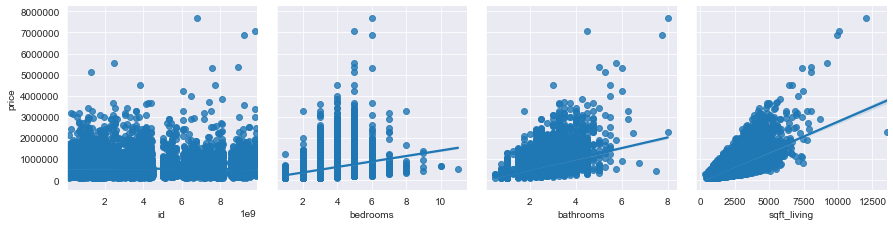

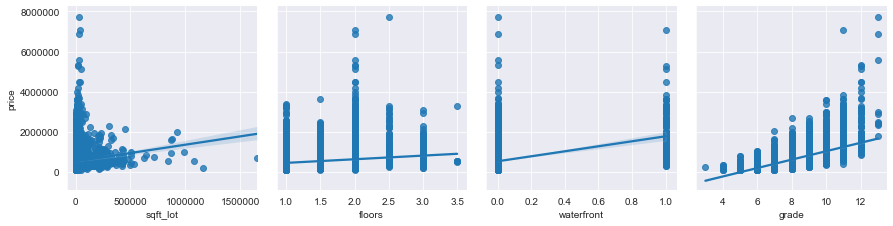

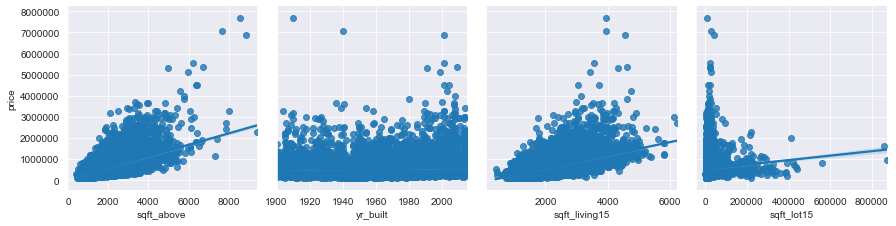

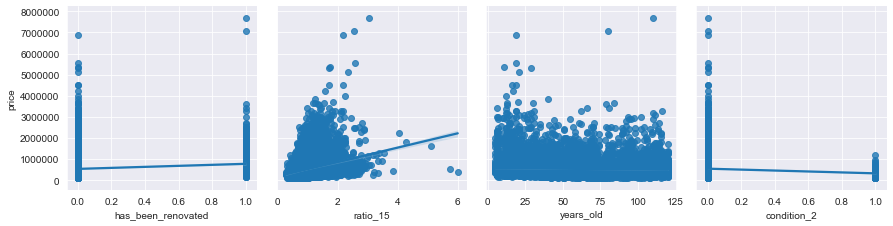

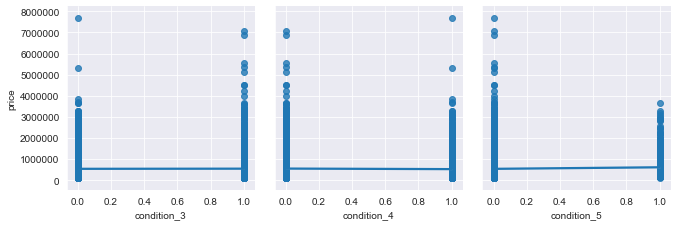

In [7]:
# Break the columns in groups to plot 4 on a row at a time, vs the target
df = pd.concat([X_train, y_train], axis = 1)
n = 4
features = list(X_train.drop(columns = 'date').columns)
row_groups= [features[i:i+n] for i in range(0, len(features), n) ]
for i in row_groups:
    pp = sns.pairplot(data=df, y_vars=['price'],x_vars=i, kind="reg", height=3)
# pp.savefig('../images/pairplot.png', bbox_inches='tight')

The relationship between living space and price looks the strongest so that was the feature we started to investigate further. Looking at just that variable we made a regression plot that also shows the distribution of each variable. 

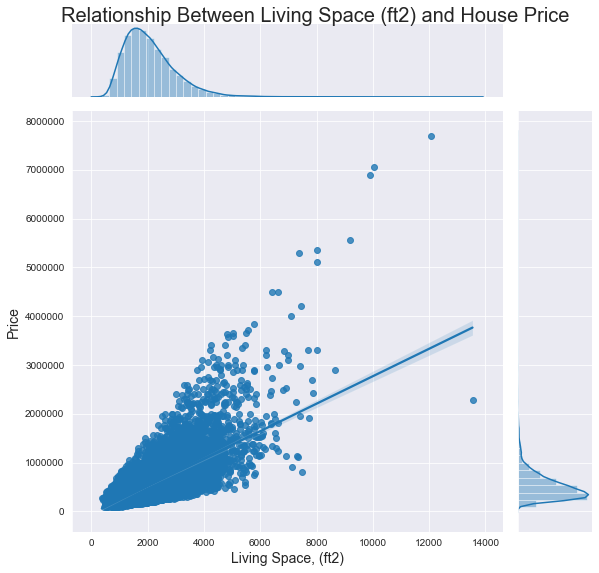

In [8]:
# Joins the test feature sqft_living with price and makes a jointplot
df = pd.concat([X_train, y_train], axis = 1)
fig = sns.jointplot(x="sqft_living", y="price", data=df, kind="reg", height = 8, ratio = 5)
fig.fig.suptitle("Relationship Between Living Space (ft2) and House Price", fontsize = 20)
fig.fig.subplots_adjust(top=0.95)
fig.set_axis_labels(xlabel = 'Living Space, (ft2)', ylabel = 'Price', fontsize = 14)
sns.set(font_scale = 1)

There is a positive relationship between the variables and both distributions have a slight skew. For the purpose of this model, this relationship will be assumed to be linear.

***
### Assessment of Correlation Between Features

Finally, we created a heat map to investigate the linearity within the features to address any possible issues of colinearity in our model as we add in additional features. Any features with a correlation value of greater than 0.7 will not be used together in iterations of a model. 


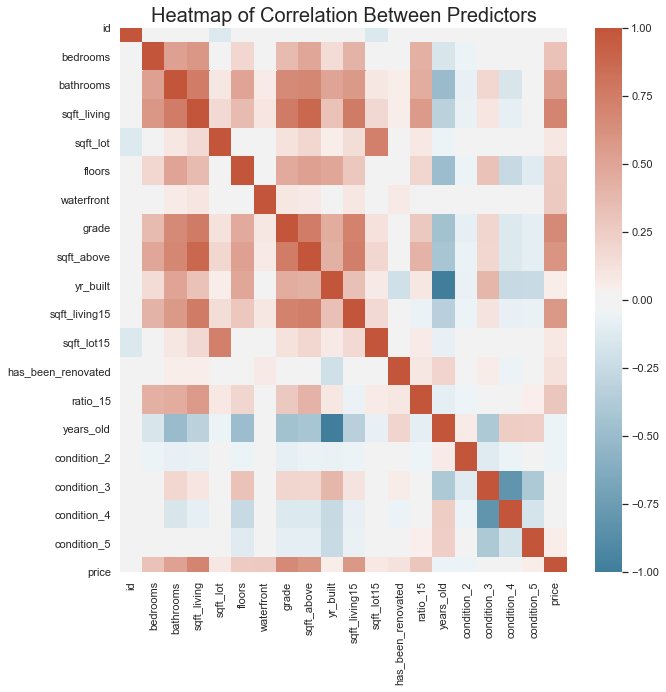

In [9]:
# Creates a heatmap of the correlation matrix
fig,ax = plt.subplots(figsize = (10, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr(), cmap = cmap)
ax.set_title('Heatmap of Correlation Between Predictors', fontsize = 20);
# fig.savefig('../images/heatmap.png', bbox_inches='tight')

As we can see above, the heat map shows that there is high correlation between variables such as sqft_lot and sqft_lots15 or sqft_living and sqft_above. But to get a more exact set of pairs of variables to be careful of, we created a new table. The code below takes the correlation absolute values, stacks them together and sorts them in descending order.

In [10]:
# create a dataframe of the correlation values.
df=X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# list and zip the variable name columns in the new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop the level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as 'cc'
df.columns = ['cc']

# drop duplicates.
df.drop_duplicates(inplace=True)

In [11]:
# select the values in the dataframe where correlation is between 0.7 and 1
df[(df.cc>.70) & (df.cc <1)]

,cc
pairs,
"(yr_built, years_old)",1.00
"(sqft_above, sqft_living)",0.88
"(condition_3, condition_4)",0.81
"(grade, sqft_living)",0.76
"(sqft_living15, sqft_living)",0.76
"(grade, sqft_above)",0.76
"(sqft_living, bathrooms)",0.75
"(sqft_living15, sqft_above)",0.73
"(sqft_lot, sqft_lot15)",0.73


Now we have a dataframe of pairs that we have to be careful with in models.

***

### Model Iteration

#### Creation of Dummy Model

First we created a dummy regressor model as a baseline. The dummy regressor uses the default of predicting the mean of the training set and was fitted to the our training X and y. We also checked the baseline score of the model.

In [12]:
# Create a baseline model equal to the mean
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.0

To find our baseline error, we predicted the y values with our model for the X_train values. By using the mean_squared_error from sklearn metrics, we found by Root Mean Square Error between our predicted and known y_train values.

In [13]:
# Baseline RMSE
y_pred = dummy.predict(X_train)
dummy_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
dummy_rmse

372015.8723643869

#### Model 1

The first model we checked was by setting only variable to `sq_ft_living`. This variable was chosen due to how most people commonly think of the square footage of the house. By using the Ordinary Least Squares function we fitted, we created our model.

In [14]:
# Model 1 with sqft_living as the only feature
formula = "price ~ sqft_living"
model_1 = lrv.run_lr(formula, X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                 1.655e+04
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:50:03   Log-Likelihood:            -2.4032e+05
No. Observations:               17277   AIC:                         4.806e+05
Df Residuals:                   17275   BIC:                         4.807e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -4.57e+04   4993.714     -9.152      

***

From the summary of our model we first check the R-squared value, which tells us the percentage of the variance in price can be explained by this model. It can only explain 48.9% of the variance in price. Then by checking the p value for the coefficient of the sqft_living variable to check if it is signficant to our model or not. Using a confidence level of 0.05, because the p value is less than 0025, we can reject the null hypothesis that the coefficient is not significantly different from zero. The coefficient for sqft_living tells us that for every square foot in the house, the price of the house increase by $281.61. 

Next we create the y prediction by using the X_train values using this first model. The Root Mean Squared Error is then calculated.

In [15]:
# RMSE of model 1 against the training set
y_pred = model_1.predict(X_train)
model_1_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_1_rmse

265871.8790296068

The Root Mean Squared Error (RMSE) is equal to 265871.88, which is less than the RMSE for the baseline model. This indicates that this model is better than our baseline model.

With the first model being only a basic linear regression model, we graph a scatter plot of the `price` vs. `sqft_living` and draw the regression line.

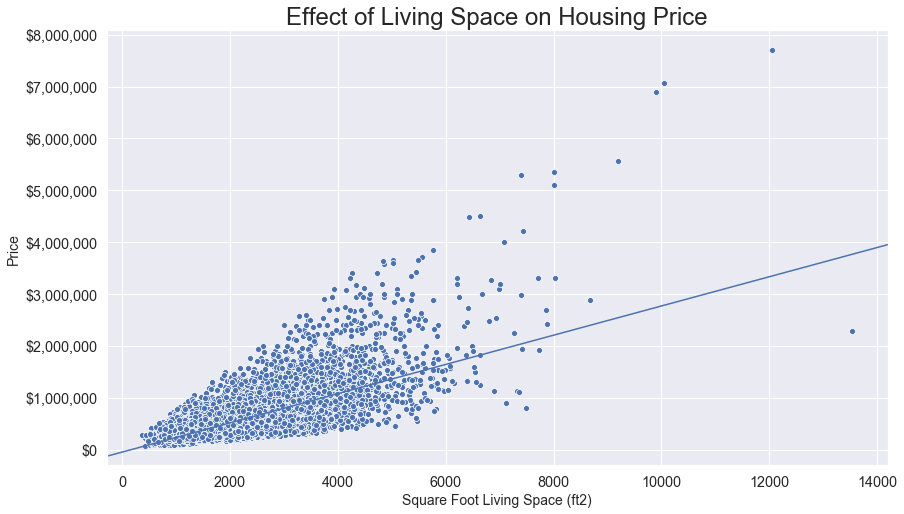

In [16]:
# Create a scatterplot showing the relationship between sqft_living and the price
fig, ax = plt.subplots(figsize = (14,8))
ax = sns.scatterplot(X_train.sqft_living, y_train)
ax.set_xlabel('Square Foot Living Space (ft2)', fontsize = 14)
ax.set_ylabel('Price', fontsize = 14)
ax.set_title('Effect of Living Space on Housing Price', fontsize = 24)
ax.tick_params(labelsize = 14)
lrv.dollar_ticks(ax)
abline_plot(model_results=model_1, ax = ax);
# fig.savefig('../images/simple_linear_regression.png', bbox_inches='tight')

#### Model 2

The second model expands on the previous model by checking the `condition` of the house. Using the `condition` variable we created dummy variables for each level of `condition` of which there are 5. Using the ols function and fitting the data, we created the second model with `price` the dependent variable and `sqft_living` and our `condition` dummy variables as the independent variables.

In [17]:
# Iteration 2 with dummy columns for condition
formula = "price ~ sqft_living + condition_2 + condition_3 + condition_4 + condition_5"
model_2 = lrv.run_lr(formula, X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     3396.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:50:03   Log-Likelihood:            -2.4021e+05
No. Observations:               17277   AIC:                         4.804e+05
Df Residuals:                   17271   BIC:                         4.805e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept        2e+04   5.77e+04      0.347      

In model 2, the R-squared value is 0.496. This is only .008 better than the previous model. When the p values are examined, the `sqft_living` is still equal to 0.000, however the conditions all have a p value greater than 0.1. Keeping are confidence levels the same, we cannot reject the null hypothesis that the coefficient is significantly different from zero. So we can conclude that `condition` feature is not significantly important to the price value.

In [18]:
# RMSE of model 2
y_pred = model_2.predict(X_train)
model_2_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_2_rmse

264173.2388625841

Checking the RMSE of model two confirms what are R-squared value implied. The RMSE decreased 1000 from the previous model, which is not significant.

#### Model 3

In the third model, the condition dummy variables are removed from the formula due to not being significant and expanded by adding `grade`, `waterfront`, `years_old`, and `ratio_15`. 

In [19]:
# Iteration 3
formula = "price ~ sqft_living + grade + waterfront + years_old + ratio_15"
model_3 = lrv.run_lr(formula, X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     6029.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:50:03   Log-Likelihood:            -2.3740e+05
No. Observations:               17277   AIC:                         4.748e+05
Df Residuals:                   17271   BIC:                         4.749e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.764e+05   1.79e+04    -54.461      

In model 3, the R-squared value is 0.636. This is an increase of 0.14 or 14% than the previous model. The p values for all the features are 0.000, thus for all coefficients the null hypothesis that the coefficient is not significantly different from zero is rejected. All the new features are significant in the prediction of price and increases the percentage of variance in price that the model is able to explain.

In [20]:
# RMSE of model 3
y_pred = model_3.predict(X_train)
model_3_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_3_rmse

224526.43788567488

The RMSE from model 3 is 224526, which is a decrease of nearly 40000. In addition to the R-squared value, this model is much better at predicting the price of homes.

#### Model 4

In the fourth model, the `sqft_living` is removed due the high multicollinearity between the variable and `grade`. While the R-squared and RMSE values were much better, it is dangerous to have high multicollinearity. When there are changes in one predictor, they are associated with changes with another preictor, thus estimates of coefficients can have a large fluctuations from small changes in the model. `bathrooms` has a high multicollinearity with `sqft_living`, but not with `grade`. We use `bathrooms` as a possible replacement for `sqft_living`.

In [21]:
# Iteration 4
formula = "price ~ bathrooms + grade + waterfront + years_old + ratio_15"
model_4 = lrv.run_lr(formula, X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     5060.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:50:03   Log-Likelihood:            -2.3833e+05
No. Observations:               17277   AIC:                         4.767e+05
Df Residuals:                   17271   BIC:                         4.767e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.512e+06   1.54e+04    -97.937      0.0

The fourth model has an R-squared value of 0.594. This is less than the 0.636 of the previous model. Though it decreases possible error due to multi-linear correlation. The p values for the features used are all 0.000, thus rejecting the null hypothesis that the coefficient is not significantly different from zero. Taking into account the multi-linear correlation, this model is the best improvement from the base model.

In [22]:
# RMSE of model 4
y_pred = model_4.predict(X_train)
model_4_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_4_rmse

236951.60963766123

The RMSE is equal 236951 which is an increase from model three, but still a 30000 decrease from model 2. 

#### Model 5

For the fifth model, the feature `has_been_renovated` was added to see if renovating a house has a predictable impact on the price.

In [23]:
# Iteration 5
formula = "price ~ bathrooms + grade + waterfront + years_old + ratio_15 + has_been_renovated"
model_5 = lrv.run_lr(formula, X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     4217.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:50:04   Log-Likelihood:            -2.3833e+05
No. Observations:               17277   AIC:                         4.767e+05
Df Residuals:                   17270   BIC:                         4.767e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.509e+06   1.56

The fifth model gives an identical $R^2$ value, and the p-value is greater than the significance level $\alpha=0.05$ so this is not a statistically significant relationship

In [24]:
# RMSE of model 5
y_pred = model_5.predict(X_train)
model_5_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_5_rmse

236936.77599405398

The RMSE is barely a decrease at all from the previous model.

#### Model 6

For the sixth model, because `has_been_renovated` and `ratio_15` had little impact on the effect, they are removed.

In [25]:
# Iteration 6
formula = "price ~ bathrooms + grade + waterfront + years_old"
model_6 = lrv.run_lr(formula, X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     6310.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        22:50:04   Log-Likelihood:            -2.3834e+05
No. Observations:               17277   AIC:                         4.767e+05
Df Residuals:                   17272   BIC:                         4.767e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.497e+06   1.52e+04    -98.755      0.0

In [26]:
# RMSE of model 6
y_pred = model_6.predict(X_train)
model_6_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_6_rmse

237124.80272911154

In [27]:
# Grabbing a random sample and predicting its price
final_model = model_6
test = X_test.sample(1, random_state = 90)
coef = final_model.params
est_price = (coef[0] +
             coef[1] * test.bathrooms +
             coef[2] * test.grade + 
             coef[3] * test.waterfront + 
             coef[4] * test.years_old
            )
print(f'The estimate price is ${int(est_price)}')
print(f'The real price is ${y_test[test.index[0]]}')

The estimate price is $576070
The real price is $562500.0


In [28]:
# Random sample house
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,has_been_renovated,ratio_15,years_old,condition_2,condition_3,condition_4,condition_5
12661,1954420230,2015-03-10,3,2.50,2030,7549,1.00,0.00,8,2030,1988,2040,7130,0,1.00,32,0,1,0,0


In [29]:
# Final Model Coefficients
final_model.params

Intercept    -1,496,765.34
bathrooms       132,448.78
grade           199,254.06
waterfront      860,856.75
years_old         4,615.06
dtype: float64

***

### Validation of Model

#### Analysis of Residuals

In [30]:
# Calculating normalized residuals
mmean = final_model.resid.mean()
mmin = final_model.resid.min()
mmax = final_model.resid.max()
normalized_residuals = (final_model.resid - mmean)/(mmax - mmin)

t = final_model.fittedvalues
tmean = final_model.resid.mean()
tmin = final_model.resid.min()
tmax = final_model.resid.max()
normalized_predicted = (t - tmean)/(tmax - tmin)

#### The assumption of normality

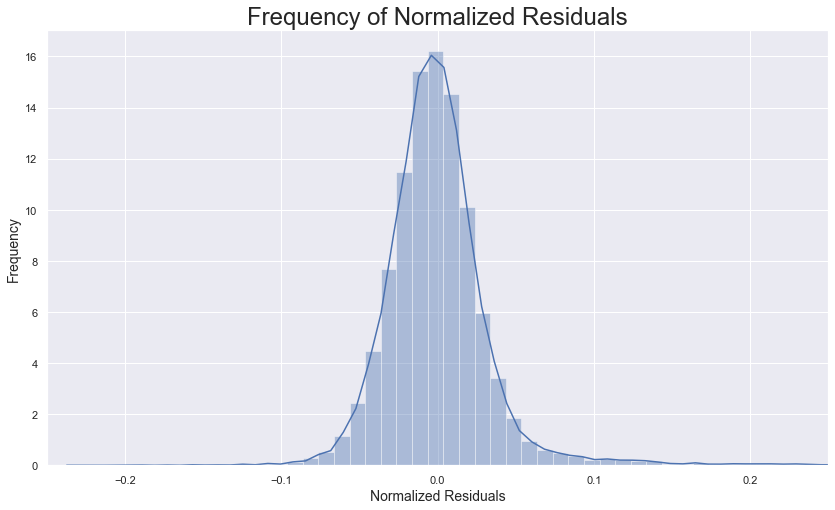

In [31]:
# Plotting frequency of the norm residuals
fig, ax = plt.subplots(figsize = (14,8))
ax.set_xlabel('Normalized Residuals', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Frequency of Normalized Residuals', fontsize = 24)
ax.set(xlim=(-0.25,.25))
sns.distplot(normalized_residuals, bins = 100);
# fig.savefig('../images/residuals_hist.png', bbox_inches='tight')

In the figure, above the residuals of the model are roughly normally distributed, so it passes the assumption of normality by visual inspection.

#### Homoskedasticity Test

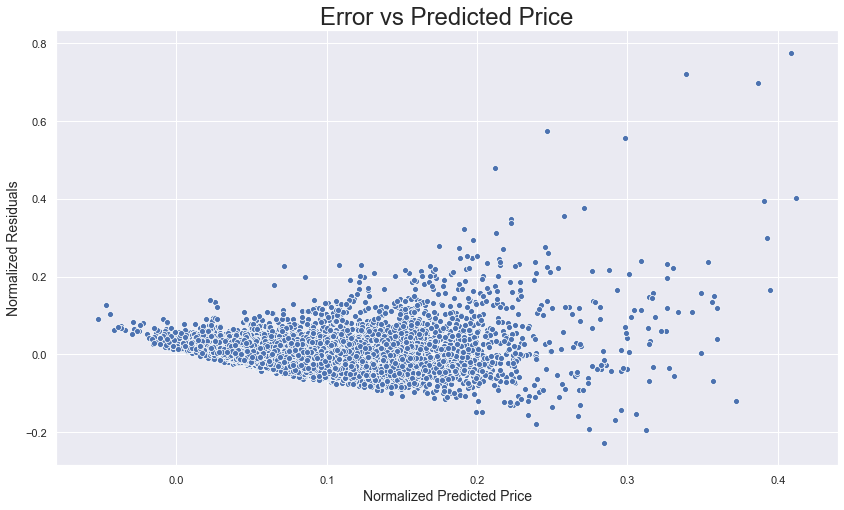

In [32]:
# Plotting the norm residuals vs the norm price
fig, ax = plt.subplots(figsize = (14,8))
ax.set_xlabel('Normalized Predicted Price', fontsize = 14)
ax.set_ylabel('Normalized Residuals', fontsize = 14)
ax.set_title('Error vs Predicted Price', fontsize = 24)
sns.scatterplot(x = normalized_predicted, y = normalized_residuals);
# fig.savefig('../images/homoskedasticity.png', bbox_inches='tight')

From the homoskedasticity test, there is an apparent bias.  This implies that there are underlying variables that influence the price that are not captured in the features of this particular model. 

#### QQ Plot

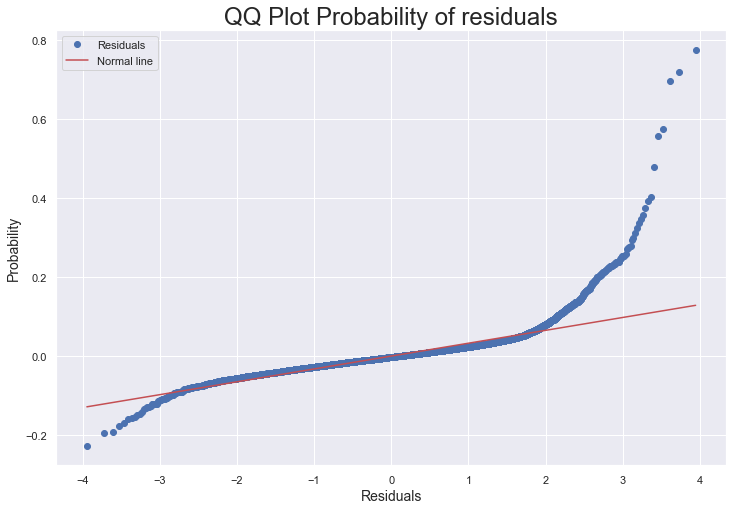

In [33]:
# QQ plot of the residuals to check the assumption of normality of errors
fig, ax = plt.subplots(figsize = (12, 8))
stats.probplot(normalized_residuals, plot=plt)
ax.set_title('QQ Plot Probability of residuals', fontsize = 24)
ax.set_xlabel('Residuals', fontsize = 14)
ax.set_ylabel('Probability', fontsize = 14)
ax.legend(['Residuals','Normal line']);
# fig.savefig('./images/qqplot.png', bbox_inches='tight')

The probability plot shows the probability of the residuals of being normally distributed.  The tails of the residuals tend away from the normality line, implying that some residuals do not come from a normal distribution.

To try to meet these assumptions, we checked how the model changes when the `grade` is binned into `low_grade`, `mid_grade` and `high_grade` and check the assumpotions again.

In [39]:
# Make a copy of the training data and bin the different grades into low-, mid-, and high.
X_train2 = X_train
X_train2['low_grade'] = [1 if x < 7 else 0 for x in X_train2['grade']]
X_train2['mid_grade'] = [1 if ((x >= 7) & (x < 10)) else 0 for x in X_train2['grade']]
X_train2['high_grade'] = [1 if x > 10 else 0 for x in X_train2['grade']]

In [40]:
# retest the model with binned grade rather than grade
formula = "price ~ bathrooms + low_grade + mid_grade + high_grade + waterfront + years_old"
model_7 = lrv.run_lr(formula, X_train2, y_train)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     3425.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:23:17   Log-Likelihood:            -2.3935e+05
No. Observations:               17277   AIC:                         4.787e+05
Df Residuals:                   17270   BIC:                         4.788e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.296e+05   1.37e+04     24.055      0.0

In [41]:
# RMSE of model 7
y_pred = model_7.predict(X_train)
model_7_rmse = np.sqrt(mean_squared_error(y_train, y_pred))
model_7_rmse

251384.56723720633

The model have worse $R^2$ and RMSE values than the previous model, while the p values are consistantly below $\alpha$. We next check the assumptions.

In [43]:
final_model = model_7
# Calculating normalized residuals
mmean = final_model.resid.mean()
mmin = final_model.resid.min()
mmax = final_model.resid.max()
normalized_residuals = (final_model.resid - mmean)/(mmax - mmin)

t = final_model.fittedvalues
tmean = final_model.resid.mean()
tmin = final_model.resid.min()
tmax = final_model.resid.max()
normalized_predicted = (t - tmean)/(tmax - tmin)

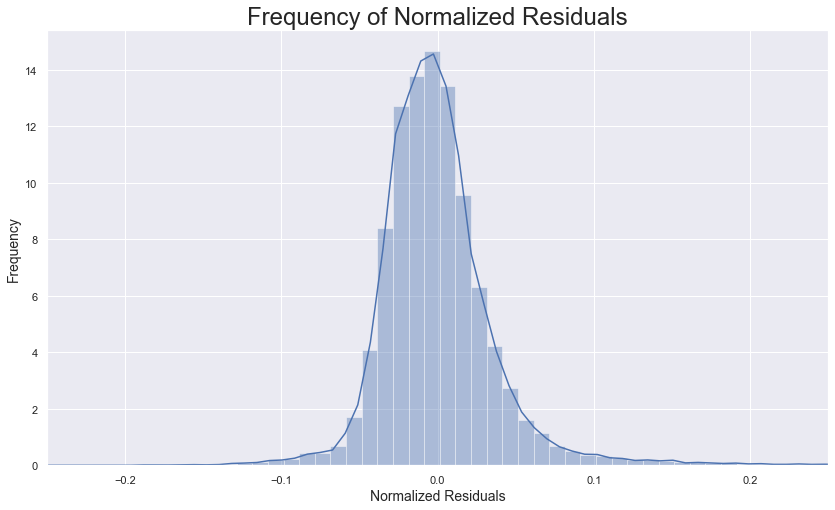

In [44]:
# Plotting frequency of the norm residuals
fig, ax = plt.subplots(figsize = (14,8))
ax.set_xlabel('Normalized Residuals', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Frequency of Normalized Residuals', fontsize = 24)
ax.set(xlim=(-0.25,.25))
sns.distplot(normalized_residuals, bins = 100);
# fig.savefig('../images/residuals_hist.png', bbox_inches='tight')

In the figure, above the residuals of this model are still roughly normally distributed, so it passes the assumption of normality by visual inspection.

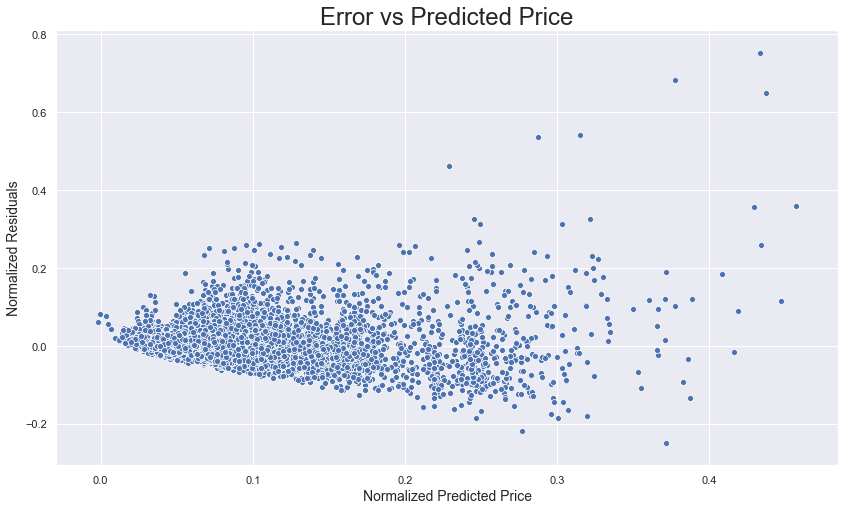

In [45]:
# Plotting the norm residuals vs the norm price
fig, ax = plt.subplots(figsize = (14,8))
ax.set_xlabel('Normalized Predicted Price', fontsize = 14)
ax.set_ylabel('Normalized Residuals', fontsize = 14)
ax.set_title('Error vs Predicted Price', fontsize = 24)
sns.scatterplot(x = normalized_predicted, y = normalized_residuals);
# fig.savefig('../images/homoskedasticity.png', bbox_inches='tight')

From the homoskedasticity test, there is an even worse apparent bias. It fails the homoskedasticity test.

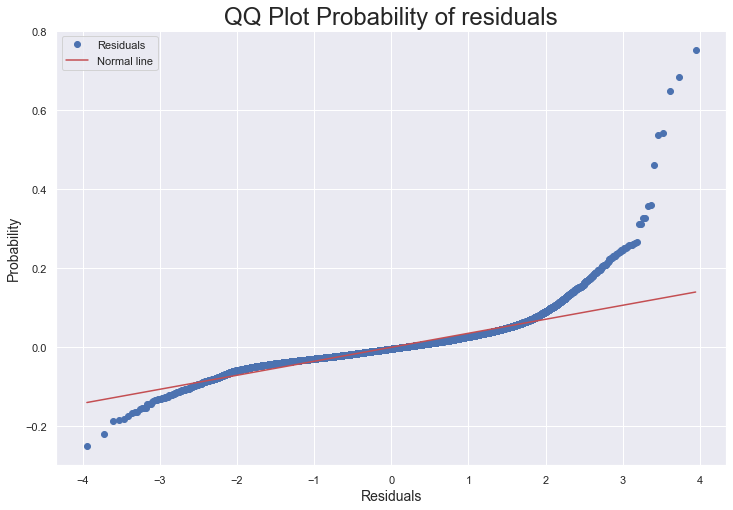

In [46]:
# QQ plot of the residuals to check the assumption of normality of errors
fig, ax = plt.subplots(figsize = (12, 8))
stats.probplot(normalized_residuals, plot=plt)
ax.set_title('QQ Plot Probability of residuals', fontsize = 24)
ax.set_xlabel('Residuals', fontsize = 14)
ax.set_ylabel('Probability', fontsize = 14)
ax.legend(['Residuals','Normal line']);
# fig.savefig('./images/qqplot.png', bbox_inches='tight')

The QQ plot shows a similar result to the previous model.

From this we can conclude that the binning of the `grade` did not help the model to meet assumptions. The final recommended model is model_6. It has the best $R^2$ and RMSE values of the models, does not contain high multicollinearity, and meets the assumptions best.

### Evaluation  <a id="Evaluation"></a>

With the final iteration of the model, using the variables `bathrooms`, `years_old`, `waterfront`, and `grade`, the regression model meets some but not all of the assumptions of linear regression.  Most of the residuals fall on a normal distribution, but there are outliers. The model also fails to meet the homoskedasticity requirement, implying that a feature is unaccounted for in the model.  The model still performs as a ballpark estimator for price however, with an $R^2 = 0.594$, and an RMSE roughly 50% smaller than the baseline model.

Root Mean Square Error of the final model

In [34]:
# Final Model RMSE against the test set
y_pred = final_model.predict(X_test)
final_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_model_rmse

216486.88492118774

Recall from earlier the baseline dummy model RMSE

In [35]:
dummy_rmse

372015.8723643869

#### Cross Validation

Below is 5-fold cross validation of the RMSE.  Computing the same regression across different random samples of the training set, we acquire multiple values of the RMSE. This value is comparable to the RMSE of the training set we computed above, supporting the robustness and of the model as it's error is consistent when sampled across different parts of the data.

In [36]:
# Calculate the mean cross validation score with 5 folds
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
X = X_train[['bathrooms','grade','waterfront','years_old']]
y = y_train
linreg = LinearRegression()
cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
mean_cv_RMSE = np.sqrt(abs(cv_5_results)) # Mean RMSE of cross val
mean_cv_RMSE

237609.7478169141

In [37]:
# R-squared of the model against the test set
y_pred = final_model.predict(X_test)
r_2_test = 1 - (sum((y_pred - y_test)**2) / sum((y_pred - y_test.mean())**2))
r_2_test

0.4166853921897504

For this particular set of training data, the model was able to predict a less amount of the variance, but it also achieves a smaller RMSE.

## Conclusion  <a id="Conclusion"></a>

From this analysis, we would conclude that the features `bathrooms`, `grade`, `waterfront`, and `years_old` are significant predictors of the price and should be used to estimate a starting 'ballpark' price estimate.  Using this price estimate, an overpriced house could have it's listing adjusted to reduce the time it spends on the market depreciating in value.  

These features were manually chosen among others due to the low correlation between them.  In this way we reduce the multicollinearity and increase the interpretability.  We would not use these to predict a definitive selling price because there numerous variables that are unaccounted for, as shown in the ~40% of unexplained variance and the presence of heteroskedasticity in the residuals.  However for a subset of houses this can give a good point of comparison.  As a next step, including additional features such as nearby ammenities, relative location, zipcode, and extra features of the house would provide a more accurate prediction of the price.  For example, certain zipcodes could be correlated to high or low price ranges that are not captured in the current model.  Including the interaction of certain features would also lead to a more accurate prediction at the expense of interpretability. 